In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [6]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'

In [7]:
files = glob.glob(f"{data_folder}\\*.parquet")
files

['C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\Data\\combined_data.parquet']

In [8]:
df_data = pd.read_parquet(files[0])

In [17]:
def budyko(df_data, show=True):
    p_mean = df_data.P.mean()
    q_mean = df_data.Q.mean()
    ep_mean = df_data.Pev.mean()
    
    df_data['Ea_P'] = 1 - df_data['Q'] / df_data['P']
    
   
    EA_P = 1 - q_mean / p_mean
    
    EP_P  = ep_mean / p_mean
    
    EP_P_max = int(EP_P + 5)
    EP_P_array = np.linspace(1e-9, EP_P_max, EP_P_max+1)
    
    budyko = (EP_P_array * np.tanh(1 / EP_P_array) * (1 - np.exp(-EP_P_array))) ** 0.5
    budyko_EP = (EP_P * np.tanh(1 / EP_P) * (1 - np.exp(-EP_P))) ** 0.5
    budyko_EA = budyko_EP * p_mean

    dS_dt = p_mean - q_mean - budyko_EA
    
   
    fig, ax = plt.subplots()
    
    ax.plot([0,1], [0,1], 'r')
    ax.plot([1, EP_P_max], [1, 1], 'b')
    ax.set_xlabel('$E_p$/P [-]')
    ax.set_ylabel('$E_A$/P [-]')

    ax.set_title('Long term water balance')
    ax.plot(EP_P, EA_P, 'o', label=f'Partioning point')
    ax.plot(EP_P_array, budyko, '--', alpha=0.6, label=f'Budyko (1948) ')
    ax.legend()
    
    if show != True:
        plt.close()
    

    return df_data, dS_dt



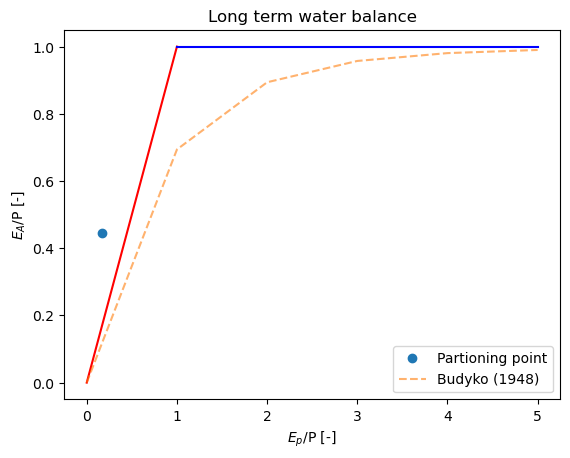

In [18]:
long_term, dS_dt  = budyko(df_data)


### Long term water balance

As can be seen in the figure, the partiononing point is outside of the red line. This means that it is outside of the energy/water limit. This is due to the fact that the actual evaporation is too low. 

In [13]:
def flow_duration(df, show=True):
    df.dropna(inplace=True)
    df_q = df[["Q"]].rename(columns={"Q":"R"})
    df_q.sort_values("R",ascending=False,inplace=True)
    df_q = df_q.reset_index().reset_index()
    df_q.set_index("index",inplace=True)
    df_q.rename(columns={"level_0":"m"}, inplace=True)
    
    n = len(df_q)
    df_q['m'] = df_q.apply(lambda x: x.m+1, axis=1)
    df_q['p'] = df_q.apply(lambda x: x.m / (n+1), axis=1)
    
    fig, ax = plt.subplots(2,1,figsize=(6,8))
    fig.tight_layout(h_pad=6)
    
    ax[0].set_ylabel("Runoff Q in $mm/d$")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    df[["Q"]].plot(ax = ax[0], color="C0", xlabel='Date')
    
    ax[1].set_ylabel("Runoff Q in $mm/d$")
    ax[1].set_xlabel("Excedance probability [-]")
    ax[1].set_title(f"Run off exceedance probability ")
    ax[1].set_yscale("log")
    ax[1].grid()
    ax[1].plot(df_q.p, df_q.R, color="C0")
    
    if show != True:
        plt.close()

    return df_q

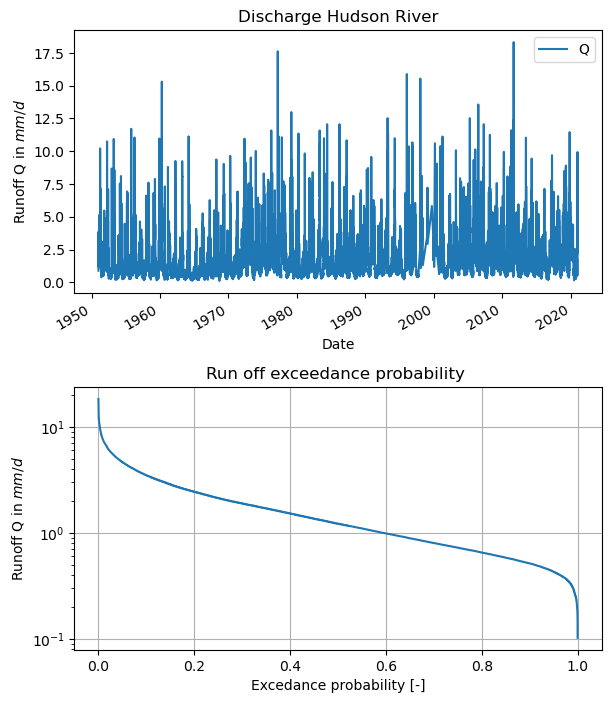

In [14]:
df = flow_duration(df_data)

In [15]:
def auto_correlation(df, show=True):
    df.dropna(inplace=True)
    lag = range(50)
    corr_coeff_1 = []

    for i in lag:
        corr_coeff_1.append(df['Q'].autocorr(lag=i))

    fig, ax = plt.subplots(2,1, figsize=(6, 8))
    fig.tight_layout(h_pad=6)
    df['Q'].plot(ax=ax[0],color="C0")

    ax[0].set_ylabel("Runoff Q in $mm/d$")
    ax[0].set_xlabel("Date")
    ax[0].set_title('Discharge Hudson River')
    
    ### new layer
    
    ax[1].plot(lag, corr_coeff_1, color="C0")
    
    ax[1].set_ylabel("Correlation Coefficient $[-]$")
    ax[1].set_xlabel("Time lag $[d]$")
    ax[1].set_title(f"Catchment")
    ax[1].grid()
    
    if show != True:
        plt.close()
    
    return corr_coeff_1

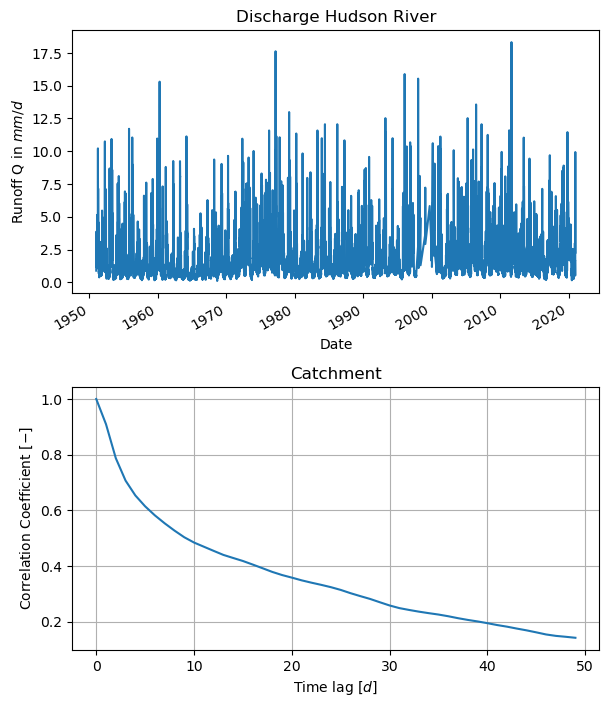

In [16]:
corr = auto_correlation(df_data)

In [19]:
# not much memory
#thre are peaks
# 

In [20]:
#storage less is important, mostly rainfall important